# `Scalar`: the heart of computational graphs

In `mlfz`, computational graphs are implemented by the `Scalar` class. (And also the `Tensor` class, but to flatten the learning curve, we'll stick to vanilla 
computational graphs without vectorization.)

You can instantiate a `Scalar` by either setting its value or using operations and functions on other `Scalar's.

In [2]:
from mlfz.nn.scalar import Scalar

a = Scalar(3)
b = Scalar(-2)

a + b

Scalar(1)

You can even randomly initialize a `Scalar` via the `Scalar.from_random` method.

In [3]:
Scalar.from_random()

Scalar(0.12194606161491517)

As `Scalar` represents a node in a computational graph, each one holds
* a numeric value,
* the backwards gradient,
* and the list of incoming edges.

Let's see these on the simple example of `a * b`.

In [4]:
a = Scalar(3)
b = Scalar(-2)

c = a * b
c.value

-6

We'll talk about the backwards gradient in detail when we discuss backpropagation and the backward pass. For now, its value is `0`, but it'll contain the derivative of the loss function with respect to the node.

In [5]:
c.backwards_grad

0

The `Scalar.prevs` attribute contains a list of `Edge` objects, each representing an incoming edge.

In [6]:
c.prevs

[Edge(prev=Scalar(3), local_grad=-2), Edge(prev=Scalar(-2), local_grad=3)]

In turn, each edge contains
* a `Scalar`,
* and the derivative of the children node, given the parent node.

In [7]:
edge_a_b = c.prevs[0]
edge_a_b.prev

Scalar(3)

In our case, the local gradient equals to $ \frac{\partial c}{\partial a} = b $, which is $ -2 $ in this example.

In [8]:
edge_a_b.local_grad

-2

Essentially, `Scalar` is a wrapper over a number. That's why functions like Python's built-in `sum` work on them:

In [9]:
sum([Scalar(1), Scalar(2)])

Scalar(3)

Let's see how to build computational graphs!

## Defining computational graphs

As you can see, the `Scalar` class is overloaded with features: it dynamically builds the underlying computational graph without you having to worry about it. Let's see an example.

In [10]:
from mlfz.nn.scalar.functional import sigmoid

a = Scalar(3)
b = Scalar(-2)
x = Scalar(0.5)

y = a * x + b

The expression `a * x + b` describes a directed graph with nodes `a`, `b`, `a * x`, `x`, and `a * x + b`. It's easier to draw a picture.

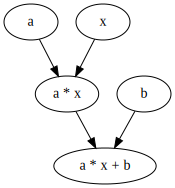

In [11]:
from graphviz import Digraph

lr_graph = Digraph()
lr_graph.node("a", "a")
lr_graph.node("b", "b")
lr_graph.node("c", "a * x")
lr_graph.node("x", "x")
lr_graph.node("d", "a * x + b")

lr_graph.edges(["ac", "xc", "cd", "bd"])

lr_graph

In `mlfz,` the computational graph is fully represented by `Scalar's and `Edge's. All you need to do is to define functions using operations and functions as building blocks. `Scalar` objects are compatible with addition, subtraction, multiplication, division, and exponentiation; that is, the operators `+`, `-`, `*`, `/`, and `**`. 

Besides those, the `mlfz.nn.scalar.functional` module contains functions like `sin`, `cos`, `exp`, and `log`.

In [12]:
from mlfz.nn.scalar.functional import sin, cos


x = Scalar(-4.6)
y = Scalar(1.3)

sin(x) + cos(y)

Scalar(1.2611898322580517)

Just to convince you that it works, here's the plot of our `sin(x) + sin(y)` function.

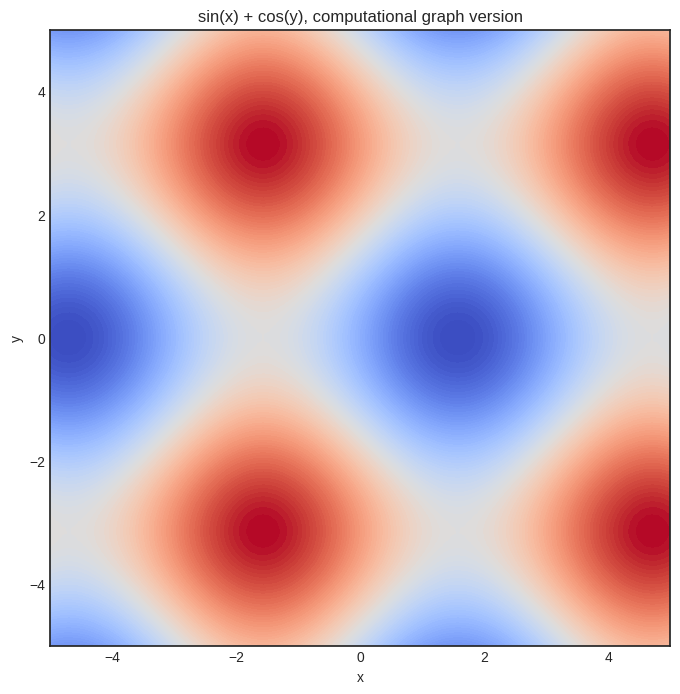

In [13]:
import matplotlib.pyplot as plt
import numpy as np


with plt.style.context("seaborn-v0_8-white"):
    plt.figure(figsize=(8, 8))
    
    res = 100
    x = np.linspace(-5, 5, res)
    y = np.linspace(-5, 5, res)
    xx, yy = np.meshgrid(x, y)
    
    zz = np.vectorize(lambda x, y: (sin(Scalar(x)) + cos(Scalar(y))).value)(xx, yy)

    plt.contourf(xx, yy, zz, levels=100, cmap='coolwarm_r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('sin(x) + cos(y), computational graph version')
    plt.show()

## The backward pass

To get a node's derivative with respect to all preceding nodes, we use the famous backpropagation algorithm, implemented via the `Scalar.backward` method.

Let's see it in action!

In [14]:
x, y = Scalar(1.2), Scalar(-6.9)
z = (sin(x) + cos(y))**2

z.backward()

Upon calling `z.backward()`, the `z`-s derivatives with respect to all preceding nodes are calculated and stored in the `backwards_grad` attribute.

In [15]:
x.backwards_grad

1.2666318116545192

In [16]:
y.backwards_grad

2.021952608019056

As

$$
\begin{align*}
\frac{\partial z}{\partial x} &= 2 \cos x \big( \sin x + \cos y \big), \\
\frac{\partial z}{\partial y} &= - 2 \sin y \big( \sin x + \cos y \big), \\
\end{align*}
$$

we can check the correctness via Python's built-in trigonometric functions from the `math` module.

In [17]:
from math import sin as sin_vanilla, cos as cos_vanilla

def z_grad(x, y):
    return (2 * cos_vanilla(x) * (sin_vanilla(x) + cos_vanilla(y)),
            -2 * sin_vanilla(y) * (sin_vanilla(x) + cos_vanilla(y)))

z_grad(x.value, y.value) == (x.backwards_grad, y.backwards_grad)

True

Yay!

`Scalar` is pretty simple to use; that was more or less all about it. In the next part, we'll use computational graphs to train our first machine learning model: a linear regression. Let's get to it!